In [8]:
import pandas as pd
import gzip
import os
import missingno as msno
import dask.dataframe as dd
import requests
import time
import io

# Récupération et traitement du fichier DVF

In [1]:
# Liste des années à télécharger
years = [2017, 2018, 2019, 2020, 2021, 2022]

In [12]:
def process_dvf(years, base_url='https://files.data.gouv.fr/geo-dvf/latest/csv/', output_file='full_dvf.csv'):
    df_list = []

    for year in years:
        start_time = time.time()

        # Étape 1: Télécharger le fichier
        url = f'{base_url}{year}/full.csv.gz'
        response = requests.get(url)
        
        if response.status_code == 200:
            decompressed_file = gzip.decompress(response.content)
            df = pd.read_csv(io.StringIO(decompressed_file.decode('utf-8')))
            print(f"Étape 1 ({year}): Téléchargement du fichier terminé - Temps écoulé: {time.time() - start_time:.2f} secondes")

            # Étape 2: Filtrer les lignes avec la valeur 'Vente' dans la colonne 'nature_mutation'
            start_time = time.time()
            df = df[df['nature_mutation'] == 'Vente']
            print(f"Étape 2 ({year}): Filtrage 'Vente' terminé - Temps écoulé: {time.time() - start_time:.2f} secondes")

            # Étape 3: Supprimer les lignes avec une valeur null dans la colonne 'surface_reelle_bati'
            start_time = time.time()
            df = df.dropna(subset=['surface_reelle_bati'])
            print(f"Étape 3 ({year}): Suppression des valeurs null dans 'surface_reelle_bati' terminée - Temps écoulé: {time.time() - start_time:.2f} secondes")

            # Étape 4: Supprimer les lignes avec une valeur null dans la colonne 'valeur_fonciere'
            start_time = time.time()
            df = df.dropna(subset=['valeur_fonciere'])
            print(f"Étape 4 ({year}): Suppression des valeurs null dans 'valeur_fonciere' terminée - Temps écoulé: {time.time() - start_time:.2f} secondes")

            # Étape 5: Filtrer les lignes avec les valeurs 'Maison' ou 'Appartement' dans la colonne 'type_local'
            start_time = time.time()
            df = df[df['type_local'].isin(['Maison', 'Appartement'])]
            print(f"Étape 5 ({year}): Filtrage 'Maison' et 'Appartement' terminé - Temps écoulé: {time.time() - start_time:.2f} secondes")

            # Étape 6: Supprimer les lignes avec une valeur null dans les colonnes 'longitude' et 'latitude'
            start_time = time.time()
            df = df.dropna(subset=['longitude', 'latitude'])
            print(f"Étape 6 ({year}): Suppression des valeurs nulles dans 'longitude' et 'latitude' effectuée - Temps écoulé: {time.time() - start_time:.2f} secondes")
            
            # Ajouter le DataFrame à la liste
            df_list.append(df)
        else:
            print(f"Erreur lors du téléchargement du fichier pour l'année {year}")

    # Concaténer les DataFrames
    concatenated_df = pd.concat(df_list, ignore_index=True)

    # Enregistrer le DataFrame concaténé dans un fichier CSV
    concatenated_df.to_csv(output_file, index=False)
    print(f'Fichier CSV concaténé enregistré : {output_file}')


In [ ]:
# Appeler la fonction avec les années souhaitées
process_dvf(years)

/var/folders/dk/nbpzskvx3m3bj_d8fcplkgkh0000gn/T/ipykernel_75783/272266931.py:13: DtypeWarning: Columns (10,12,14,16,17,18,20,22,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(decompressed_file.decode('utf-8')))


Étape 1 (2017): Téléchargement du fichier terminé - Temps écoulé: 9.20 secondes
Étape 2 (2017): Filtrage 'Vente' terminé - Temps écoulé: 0.46 secondes
Étape 3 (2017): Suppression des valeurs null dans 'surface_reelle_bati' terminée - Temps écoulé: 0.24 secondes
Étape 4 (2017): Suppression des valeurs null dans 'valeur_fonciere' terminée - Temps écoulé: 0.15 secondes
Étape 5 (2017): Filtrage 'Maison' et 'Appartement' terminé - Temps écoulé: 0.15 secondes
Étape 6 (2017): Suppression des valeurs nulles dans 'longitude' et 'latitude' effectuée - Temps écoulé: 0.13 secondes


# Analyse du fichier final

In [10]:
full_dvf= pd.read_csv('full_dvf.csv')

/var/folders/dk/nbpzskvx3m3bj_d8fcplkgkh0000gn/T/ipykernel_75783/944912604.py:1: DtypeWarning: Columns (8,10,12,14,16,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  full_dvf= pd.read_csv('full_dvf.csv')


<AxesSubplot:>

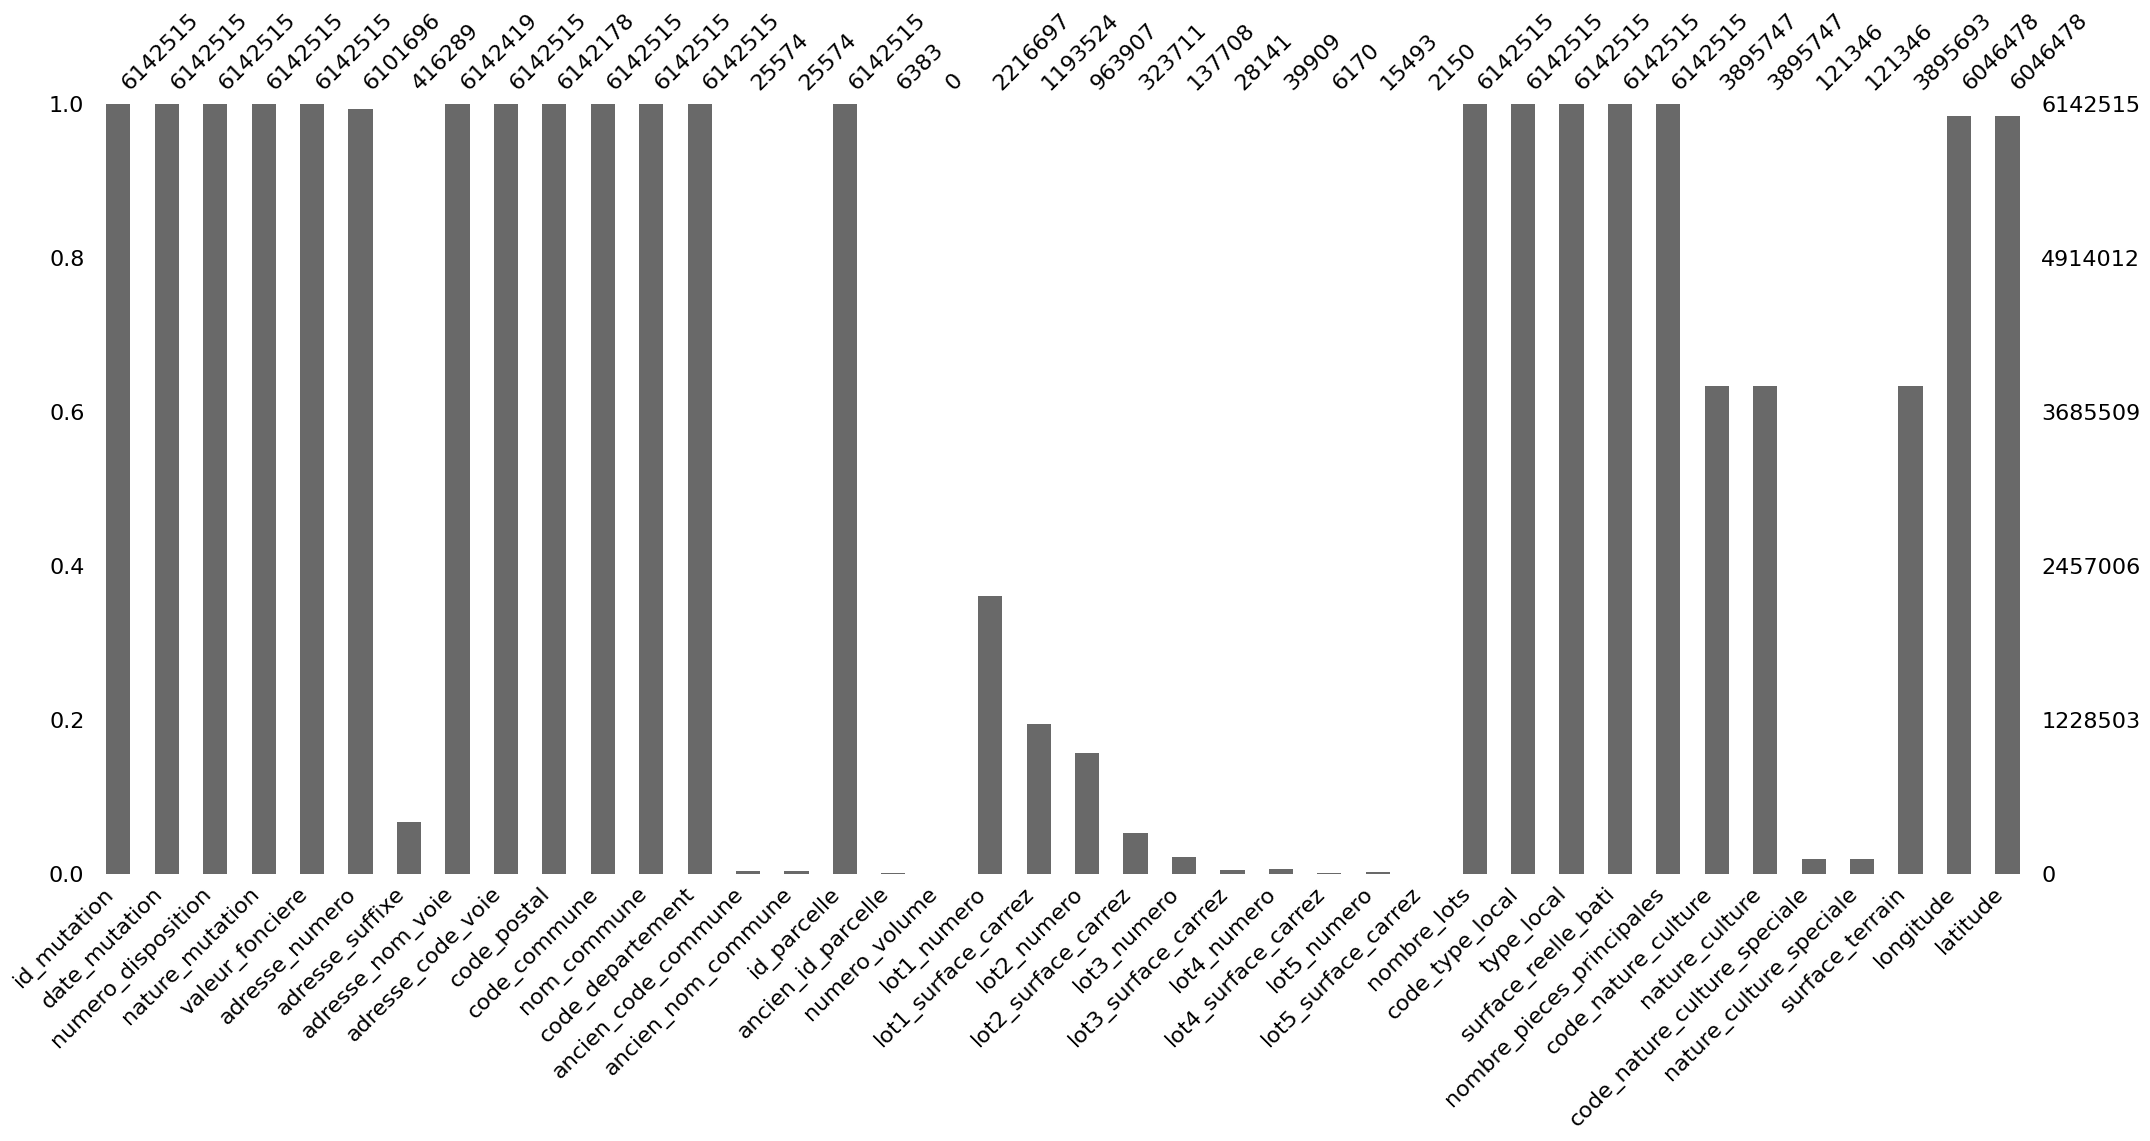

In [11]:
msno.bar(full_dvf)